In [64]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import IPython
import IPython.display

from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tf.__version__

'2.8.0'

In [65]:
import pandas as pd
from pymatreader import read_mat
data = read_mat('data/Zero_Maze/608034_409/Day_1/Trial_001_0/binned_behavior.mat')
data.keys()
behavior = pd.DataFrame(data['binned_behavior'])
behavior.head()

,0,1,2,3,4,5,6,7,8,9,...,6290,6291,6292,6293,6294,6295,6296,6297,6298,6299
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data2 = read_mat('data/Zero_Maze/608034_409/Day_1/Trial_001_0/binned_zscore.mat')
data2.keys()
zscore = pd.DataFrame(data2['binned_zscore'])
zscore.head()

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,2.640148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.929051,1.774913,1.218389,-2.705746,0.697715,0.322647,0.298543,-0.371592,-1.450060,1.252282,...,0.099726,0.574819,0.746942,1.512385,0.208940,0.105149,0.510862,0.519161,0.217849,-0.086961
2,1.088615,1.736515,1.439487,-2.908194,0.627768,0.413796,0.244992,-0.566208,-1.452057,1.018918,...,0.092498,0.829649,1.059203,1.355386,0.294898,0.112271,0.391759,0.509411,0.198977,-0.193007
3,-2.618913,1.652854,1.786667,-2.439361,0.966685,0.585865,0.233453,-0.156940,-1.376652,1.033326,...,0.319163,0.973076,0.466399,1.201297,0.261084,0.025030,0.285603,0.481374,0.595804,-0.187173
4,0.138016,1.163155,2.104050,-2.734363,0.974884,0.651812,0.143408,-0.178744,-1.541030,1.174222,...,0.134246,0.940835,0.871027,1.134786,0.111858,0.041304,0.291258,0.452129,0.408103,0.001633


In [67]:
behavior = behavior.T
behavior.columns = ['behavior_1', 'behavior_2']
df_merge = pd.concat([zscore, behavior], axis=1)
df_merge.columns.tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 'behavior_1',
 'behavior_2']

In [68]:
df_merge = df_merge[(df_merge['behavior_1'] != 0) | (df_merge['behavior_2'] != 0)]

df_merge.drop(['behavior_2'], axis=1, inplace=True)
df_merge.shape
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,behavior_1
73,-0.167827,1.985056,1.836544,1.334266,0.399327,0.073492,1.042055,2.533030,2.612819,1.305720,...,1.300602,0.744457,1.948461,0.017943,0.429803,-0.049053,-0.203634,0.322033,-0.258662,1
97,0.770978,1.727913,3.358370,0.255283,0.366916,0.324529,0.914050,2.216065,-0.502113,2.606097,...,0.681148,3.079515,2.538494,0.330118,0.383909,0.750582,0.290860,0.292462,0.933846,0
98,0.504819,1.924167,2.827576,0.119462,0.289120,0.543961,0.566864,2.175174,-0.192792,2.232001,...,0.567187,3.419712,2.242034,-0.018431,0.336230,0.773685,0.361234,0.302041,0.860172,0
99,1.816454,1.598530,2.168710,0.305105,0.324066,0.286760,0.851268,2.045893,0.426916,1.830557,...,0.980704,2.604274,1.834002,0.122452,0.433774,0.736375,0.085997,0.514667,0.399926,1
100,0.569652,1.507102,1.684682,0.384170,0.427193,0.075966,0.581672,2.220822,0.698762,1.248236,...,1.391215,2.844209,1.325744,0.088723,0.534250,0.738672,0.000959,0.134676,0.398196,1


In [69]:
column_indices = {name: i for i, name in enumerate(df_merge.columns)}

n = len(df_merge)
train_df = df_merge[0:int(n*0.7)]
val_df = df_merge[int(n*0.7):int(n*0.9)]
test_df = df_merge[int(n*0.9):]

num_features = df_merge.shape[1]

In [87]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [88]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [89]:
w1 = WindowGenerator(input_width=110, label_width=1, shift=10,
                     label_columns=['behavior_1'])
w1

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109]
Label indices: [119]
Label column name(s): ['behavior_1']

In [90]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [91]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 120, 111)
Inputs shape: (3, 110, 111)
Labels shape: (3, 1, 1)


In [92]:
def plot(self, model=None, plot_col='behavior_1', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [93]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [94]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [156]:
## convolutional neural network

CONV_WIDTH = 1000
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=100,
    shift=1,
    label_columns=['behavior_1'])

conv_window

Total window size: 1001
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

In [157]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


In [158]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 1000, 111)
Output shape: (32, 1, 1)


In [162]:
from tensorflow.keras.optimizers import Adam
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  #model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              #metrics=['sparse_categorical_accuracy'])


  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, validation_data=window.val,
                      epochs=MAX_EPOCHS,batch_size=16, validation_freq=1)
  return history

In [163]:
history = compile_and_fit(conv_model, conv_window)

val_performance = {}
performance = {}

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

8/8 [==============================] - 0s 26ms/step - loss: 0.3937 - mean_absolute_error: 0.6205


In [164]:
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['behavior_1'])

wide_conv_window

Total window size: 1001
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

In [165]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 1000, 111)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


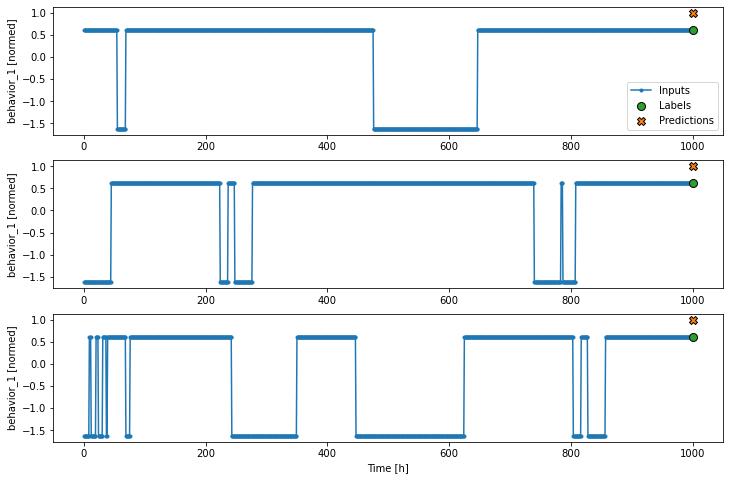

In [166]:
wide_conv_window.plot(conv_model)

Total window size: 700
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

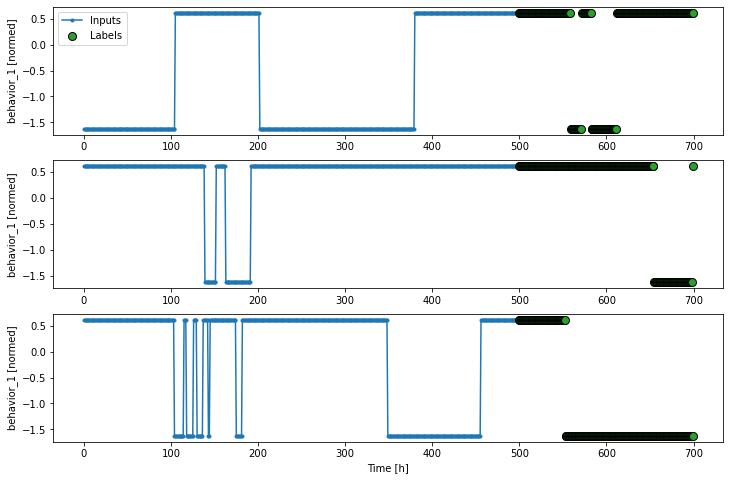

In [167]:
# multiple steps CNN

OUT_STEPS = 200
multi_window = WindowGenerator(input_width=500,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

17/17 [==============================] - 0s 17ms/step - loss: 3.0762 - mean_absolute_error: 1.1527


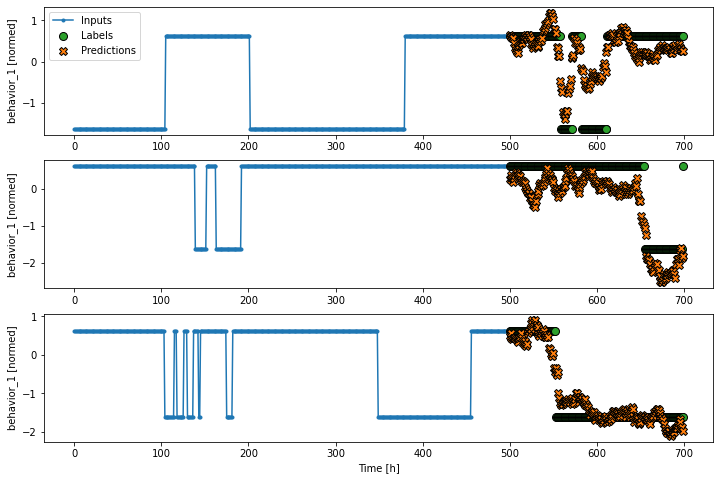

In [168]:
CONV_WIDTH = 100
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}


multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)